In [124]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')

# out_prncp와 완전 동일함, funded_amnt_inv는 funded_amnt와 유의미한 차이를 못발견함
# df=df.drop(['out_prncp_inv'], axis=1)
df = df.drop(['out_prncp_inv', 'funded_amnt_inv', 'acc_now_delinq'], axis=1)
df_test = df_test.drop(['out_prncp_inv', 'funded_amnt_inv', 'acc_now_delinq'], axis=1)

In [126]:
df['my_multiple'] = df['int_rate']*df['dti']
df['my_multiple2'] = np.log(df['annual_inc']*df['fico_range_low'])
df['my_multiple6'] = df['revol_util']/(df['revol_bal']+0.0000001)
df['my_multiple7'] = df['int_rate']*df['funded_amnt']/np.log(df['tot_cur_bal']*df['fico_range_low']+2)
df['my_multiple11'] = df['installment']/ df['annual_inc']

In [127]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# # 최적화 한걸로 ensemble 진행 ######## test9번 ##########
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
rnd_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=150, random_state=42)
lgbm_clf = LGBMClassifier(max_depth=11, n_estimators=150, random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth=7, n_estimators=200, eval_metric='logloss', random_state=42) # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)


정확도: 0.7303
정밀도: 0.5674
재현율: 0.7439
AUC: 0.7338
F1: 0.6437


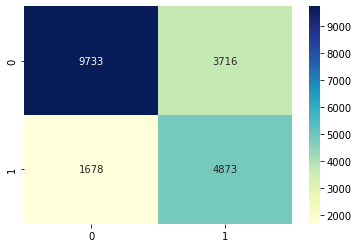

In [123]:
# 평가진행
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.34) # 0.6500-> 0.6373하이퍼파라미터 튜닝안하면 낮긴하네-> 고학습 그래봐야 0.6400

In [108]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# 위에서 했던 전처리 수행
df_test['my_multiple'] = df_test['int_rate']*df_test['dti']
df_test['my_multiple2'] = np.log(df_test['annual_inc']*df_test['fico_range_low'])
df_test['my_multiple6'] = df_test['revol_util']/(df_test['revol_bal']+0.0000001)
df_test['my_multiple7'] = df_test['int_rate']*df_test['funded_amnt']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low']+2)
df_test['my_multiple11'] = df_test['installment']/ df_test['annual_inc']

submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.37
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_15.csv', index=False)